Semantic Segmentation 
============

In this exercise you are going to work on a computer vision task called semantic segmentation. In comparison to image classification the goal is not to classify an entire image but each of its pixels separately. This implies that the  output of the network is not a single scalar but a segmentation with the same shape as the input image. Think about why you should rather use convolutional than fully-connected layers for this task!

Since we already introduced the basics of PyTorch and how to train a NN we leave the model design and architecture as well as the training up to you. We only provide you with the train, validation and test dataset and recommend you to look for inspirational, existing PyTorch implementations. Due to the fairly small size of the segmentation dataset you should not train a model from scratch but consider to (at least partially) finetune weights of an already existing model.

The infamous  [Fully Convolutional Networks for Semantic Segmentation](https://people.eecs.berkeley.edu/~jonlong/long_shelhamer_fcn.pdf) paper might help you with finding a suitable segmentation model and architecture.

<img src="https://camo.githubusercontent.com/d10b897e15344334e449104a824aff6c29125dc2/687474703a2f2f63616c76696e2e696e662e65642e61632e756b2f77702d636f6e74656e742f75706c6f6164732f646174612f636f636f7374756666646174617365742f636f636f73747566662d6578616d706c65732e706e67">

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import os
path = "/content/drive/My Drive/TUM/SS19/I2DL/exercises/exercise_3"
os.chdir(path)

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import torch

from exercise_code.data_utils import SegmentationData, label_img_to_rgb

#torch.set_default_tensor_type('torch.FloatTensor')
#set up default cuda device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

MSRC-v2 Segmentation Dataset
================

Make yourself familiar with the segmentation dataset and how we implemented the `SegmentationData` class in `exercise_code/data_utils.py`. Furthermore have a look at the labels described in `data/segmentation_data/info.html`. Especially note the label `unlabeled`. Pixels with the label `unlabeled` should neither be considered in your loss nor in the accuracy of your segmentation.

In [0]:
train_data = SegmentationData(image_paths_file='datasets/segmentation_data/train.txt')
val_data = SegmentationData(image_paths_file='datasets/segmentation_data/val.txt')

Train size: 276
Validation size: 59
Img size:  torch.Size([3, 256, 256])
Segmentation size:  torch.Size([256, 256])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


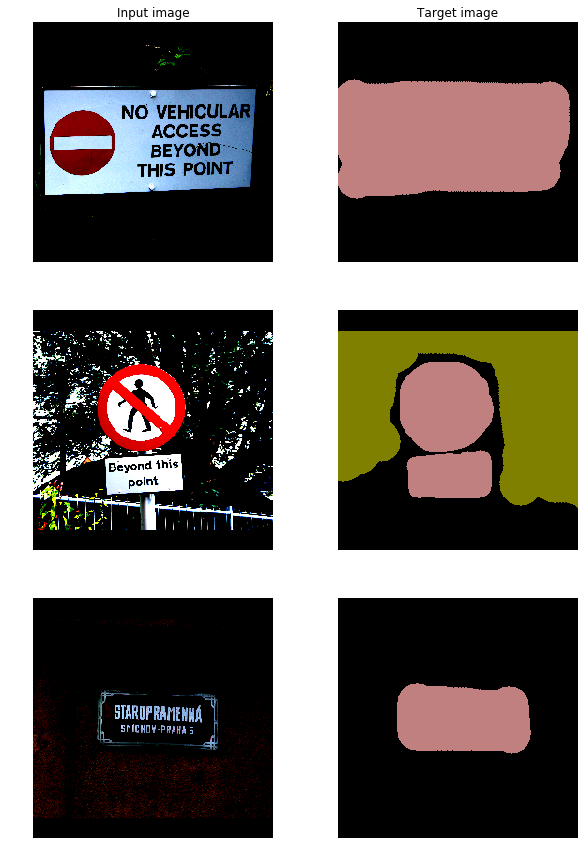

In [5]:
print("Train size: %i" % len(train_data))
print("Validation size: %i" % len(val_data))
print("Img size: ", train_data[0][0].size())
print("Segmentation size: ", train_data[0][1].size())

num_example_imgs = 3
plt.figure(figsize=(10, 5 * num_example_imgs))
for i, (img, target) in enumerate(train_data[:num_example_imgs]):
    # img
    plt.subplot(num_example_imgs, 2, i * 2 + 1)
    plt.imshow(img.numpy().transpose(1,2,0))
    plt.axis('off')
    if i == 0:
        plt.title("Input image")
    
    # target
    plt.subplot(num_example_imgs, 2, i * 2 + 2)
    plt.imshow(label_img_to_rgb(target.numpy()))
    plt.axis('off')
    if i == 0:
        plt.title("Target image")
plt.show()

Design and Train your Network
==========

Implement your network architecture in `exercise_code/classifiers/segmentation_nn.py` and adapt your `Solver` to process segmentation labels. To compensate for the dimension reduction of a typical convolution layer, you should probably include a `nn.Upsample` layer near the end of your network. Also remember to consider finetuning a model instead of training it from scratch.

Up until now we only used the default loss function (`nn.CrossEntropyLoss`) of our `Solver` class. However, in order to ignore the `unlabeled` pixels for the computation of our loss, we have to use a customized version of the loss for the initializtation of the `Solver` class. The `ignore_index` argument of the loss can be used to filter the `unlabeled` pixels and computes the loss only over remaining pixels.

Step by step:
1. Initialize training and validation data loaders.
2. Design and initialize a convolutional neural network architecture that has input (N, C, H, W) and output (N, num_classes, H, W) and is based on an already pretrained network.
3. Initialize a solver with a loss function that considers the `unlabeled` pixels.
4. Adjust the logging of your solver to account for the `unlabeled` pixels.
5. Train a segmentation model.

In [0]:
from exercise_code.segmentation_nn import VGGNet
from exercise_code.segmentation_nn import SegmentationNN
from exercise_code.segmentation_nn import FCN8s
from exercise_code.segmentation_nn import FCN32s
from exercise_code.solver import Solver
import torch.nn.functional as F

torch.cuda.empty_cache()

models = []
for batch_size in [6]:
  for lr in [1e-5, 5e-5, 1e-4, 5e-4, 1e-3]:
    for wd in [0]:
      print("model with bs:{}, lr:{} and wd:{}".format(batch_size,lr,wd))
      train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=4)
      val_loader = torch.utils.data.DataLoader(val_data, batch_size=1, shuffle=False, num_workers=4)

      vgg_model = VGGNet(requires_grad=True,model='vgg16')
      model = FCN8s(pretrained_net=vgg_model,n_class=23)
      model.to(device)
      solver = Solver(optim_args={"lr": lr, "weight_decay": wd},
                    loss_func=torch.nn.CrossEntropyLoss(size_average=True, ignore_index=-1))
      solver.train(model, train_loader, val_loader, log_nth=5, num_epochs=50)
      models.append(model)

model with bs:6, lr:1e-05 and wd:0
START TRAIN.
Epoch: 1/50


/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


Training loss: 0.5395 	Validation loss : 3.2080
Training Acc: 0.0334 	Validation Acc : 0.0346
Epoch: 2/50
Training loss: 0.5331 	Validation loss : 3.1759
Training Acc: 0.0421 	Validation Acc : 0.0525
Epoch: 3/50
Training loss: 0.5253 	Validation loss : 3.1113
Training Acc: 0.0582 	Validation Acc : 0.0794
Epoch: 4/50
Training loss: 0.5144 	Validation loss : 3.0271
Training Acc: 0.0876 	Validation Acc : 0.1224
Epoch: 5/50
Training loss: 0.5017 	Validation loss : 2.9400
Training Acc: 0.1308 	Validation Acc : 0.1709
Epoch: 6/50
Training loss: 0.4905 	Validation loss : 2.8576
Training Acc: 0.1727 	Validation Acc : 0.2128
Epoch: 7/50
Training loss: 0.4794 	Validation loss : 2.7862
Training Acc: 0.2100 	Validation Acc : 0.2575
Epoch: 8/50
Training loss: 0.4687 	Validation loss : 2.7285
Training Acc: 0.2516 	Validation Acc : 0.2907
Epoch: 9/50
Training loss: 0.4586 	Validation loss : 2.6565
Training Acc: 0.2847 	Validation Acc : 0.3250
Epoch: 10/50
Training loss: 0.4511 	Validation loss : 2.62

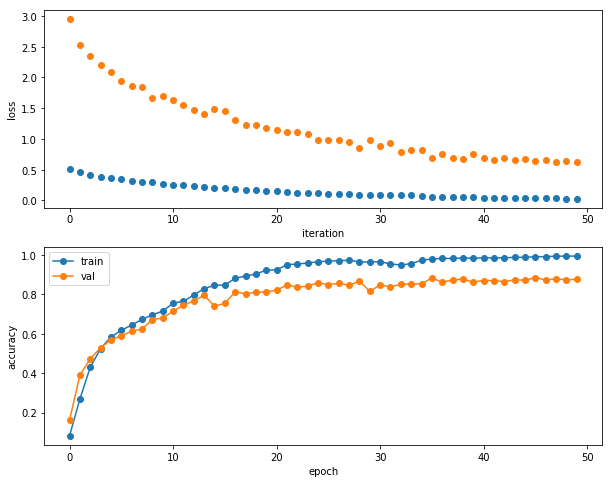

In [35]:
plt.subplot(2, 1, 1)
plt.plot(solver.train_loss_history, 'o')
plt.plot(solver.val_loss_history, 'o')
plt.xlabel('iteration')
plt.ylabel('loss')

plt.subplot(2, 1, 2)
plt.plot(solver.train_acc_history, '-o')
plt.plot(solver.val_acc_history, '-o')
plt.legend(['train', 'val'], loc='upper left')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

# Test your Model

In [0]:
for model in models:
  test_data = SegmentationData(image_paths_file='datasets/segmentation_data_test/test.txt')
  test_loader = torch.utils.data.DataLoader(test_data,
                                            batch_size=1,
                                            shuffle=False,
                                            num_workers=4)

  test_scores = []
  model.eval()
  for inputs, targets in test_loader:
      inputs, targets = inputs.to(device), targets.to(device)

      outputs = model.forward(inputs)
      _, preds = torch.max(outputs, 1)
      targets_mask = targets >= 0
      test_scores.append(np.mean((preds == targets)[targets_mask].data.cpu().numpy()))

  model.train()
  print(np.mean(test_scores))

In [0]:
test_scores = []
model1.eval()
for inputs, targets in test_loader:
    inputs, targets = inputs.to(device), targets.to(device)
    
    outputs = model1.forward(inputs)
    _, preds = torch.max(outputs, 1)
    targets_mask = targets >= 0
    test_scores.append(np.mean((preds == targets)[targets_mask].data.cpu().numpy()))
    
model1.train()
np.mean(test_scores)

In [0]:
test_scores = []
model2.eval()
for inputs, targets in test_loader:
    inputs, targets = inputs.to(device), targets.to(device)
    
    outputs = model2.forward(inputs)
    _, preds = torch.max(outputs, 1)
    targets_mask = targets >= 0
    test_scores.append(np.mean((preds == targets)[targets_mask].data.cpu().numpy()))
    
model2.train()
np.mean(test_scores)

In [0]:
test_scores = []
model3.eval()
for inputs, targets in test_loader:
    inputs, targets = inputs.to(device), targets.to(device)
    
    outputs = model2.forward(inputs)
    _, preds = torch.max(outputs, 1)
    targets_mask = targets >= 0
    test_scores.append(np.mean((preds == targets)[targets_mask].data.cpu().numpy()))
    
model3.train()
np.mean(test_scores)

# Visualization

In [0]:
num_example_imgs = 4
plt.figure(figsize=(15, 5 * num_example_imgs))
for i, (img, target) in enumerate(test_data[:num_example_imgs]):
    inputs = img.unsqueeze(0)
    inputs = inputs.to(device)
    
    outputs = model.forward(inputs)
    _, preds = torch.max(outputs, 1)
    pred = preds[0].data.cpu()
    
    img, target, pred = img.numpy(), target.numpy(), pred.numpy()
    
    # img
    plt.subplot(num_example_imgs, 3, i * 3 + 1)
    plt.axis('off')
    plt.imshow(img.transpose(1,2,0))
    if i == 0:
        plt.title("Input image")
    
    # target
    plt.subplot(num_example_imgs, 3, i * 3 + 2)
    plt.axis('off')
    plt.imshow(label_img_to_rgb(target))
    if i == 0:
        plt.title("Target image")

    # pred
    plt.subplot(num_example_imgs, 3, i * 3 + 3)
    plt.axis('off')
    plt.imshow(label_img_to_rgb(pred))
    if i == 0:
        plt.title("Prediction image")
    
plt.show()

## Visualize Filter Weights
You can visualize the convolutional filters of the very first layer by running the following cell. The kernels should exhibit clear structures of differently oriented edges, corners and circles.

In [0]:
from exercise_code.vis_utils import visualize_grid

# first (next) parameter should be convolutional
conv_params = next(model.parameters()).data.cpu().numpy()
grid = visualize_grid(conv_params.transpose(0, 2, 3, 1))
plt.imshow(grid.astype('uint8'))
plt.axis('off')
plt.gcf().set_size_inches(6, 6)
plt.show()

## Save the Model and Submission

When you are satisfied with your training, save the model for submission. In order to be eligible for the bonus points you have to achieve an accuracy above __60%__.

In [37]:
model.save("models/segmentation_nn.model")

Saving model... models/segmentation_nn.model


## Possible Next Steps

1. Implement and integrate a task specific metric such as [Intersection over Union (IoU)](http://www.pyimagesearch.com/2016/11/07/intersection-over-union-iou-for-object-detection/)
2. Hyperparameter optimization
3. Data augmentation ([PyTorch tutorial](http://pytorch.org/tutorials/beginner/data_loading_tutorial.html))